### Statement of the problem:

CoverMyMeds Challenge Problem
>At CoverMyMeds, time series analysis forms the backbone of the financial projections we make at the beginning of each fiscal year and helps us set realistic but challenging company goals.  Many of our products have multiple customers whose behaviors might (or might not) influence each other.  We are presenting daily volume (can be thought of as purchases) of one product for three customers. Questions that you should answer in this project are the following: 
>* What trends are in the data at the daily, monthly, and yearly levels?
>* What variables do and do not affect daily volume?
>* How does the behavior of one customer affect the behavior of the other customers?
>* How accurately can you predict what will happen in 2019 at the monthly and yearly levels?
>* How accurate are your projections 1 month, 3 months, and 6 months after the  day they were forecasted from?

### ARIMA Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
np.random.seed(1)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_parquet('data/cmm_erdos_bootcamp_2020_timeseries.pq', engine='auto')
df['date'] = pd.to_datetime(df['date_val'], yearfirst=True)
df.set_index(['date'], inplace = True)
df_new = df.drop(columns = ['date_val','calendar_year', 'calendar_month', 'calendar_day', 'day_of_week'])
df_new = df_new.rename(columns={'volume_A': 'vol_A', 'volume_B': 'vol_B', 'volume_C': 'vol_C'})
df_new = df_new.asfreq(freq='D')

In [441]:
from models.models import Data_Pipe, ARIMA_model

para_model = {'window': 365, 'scale': False, 'scale_type': 'max_min', 'smooth': False,  
              'target': 'vol_A', 'external': 'vol_C', 
              'dtype': None, 'p': 7, 'q': 0, 'd': 0}
#para_model.update({'dtype': 'log_diff'})

In [415]:
model.build_model()
model.fit_model()
model.get_prediction()

Average daily forecasting error:

In [416]:
model.error_rate[-len(model.test):].mean()

9.424534801767816

Error on the total sale volume over the forecast period:

In [417]:
pred = model.combine_data.fit_data[-len(model.test):]
true = model.combine_data.real_data[-len(model.test):]
100*np.abs((pred-true).sum()/true.sum())

5.465268337306379

In [442]:
montly_forecast_A_total = []
montly_forecast_A_daily = []
for i in range(1, 13):
    model = ARIMA_model(df_new.loc[:'2019-'+str(i)+'-1'], **para_model)
    model.build_model()
    model.fit_model()
    model.get_prediction()
    pred = model.combine_data.fit_data[-len(model.test):]
    true = model.combine_data.real_data[-len(model.test):]
    montly_forecast_A_total.append(100*np.abs((pred-true).sum()/true.sum()))
    montly_forecast_A_daily.append(model.error_rate[-len(model.test):].mean())

In [443]:
# model (p=7,q=0, d=0) ext = 'vol_C'
montly_forecast_A = {'daily': montly_forecast_A_daily, 
              'total': montly_forecast_A_total}

In [434]:
# model (p=7,q=0, d=0) ext = 'vol_C'
montly_forecast_B = {'daily': montly_forecast_B_daily, 
              'total': montly_forecast_B_total}
# model (p=7,q=0, d=0) ext = 'vol_B'
montly_forecast_C = {'daily': montly_forecast_C_daily, 
              'total': montly_forecast_C_total}

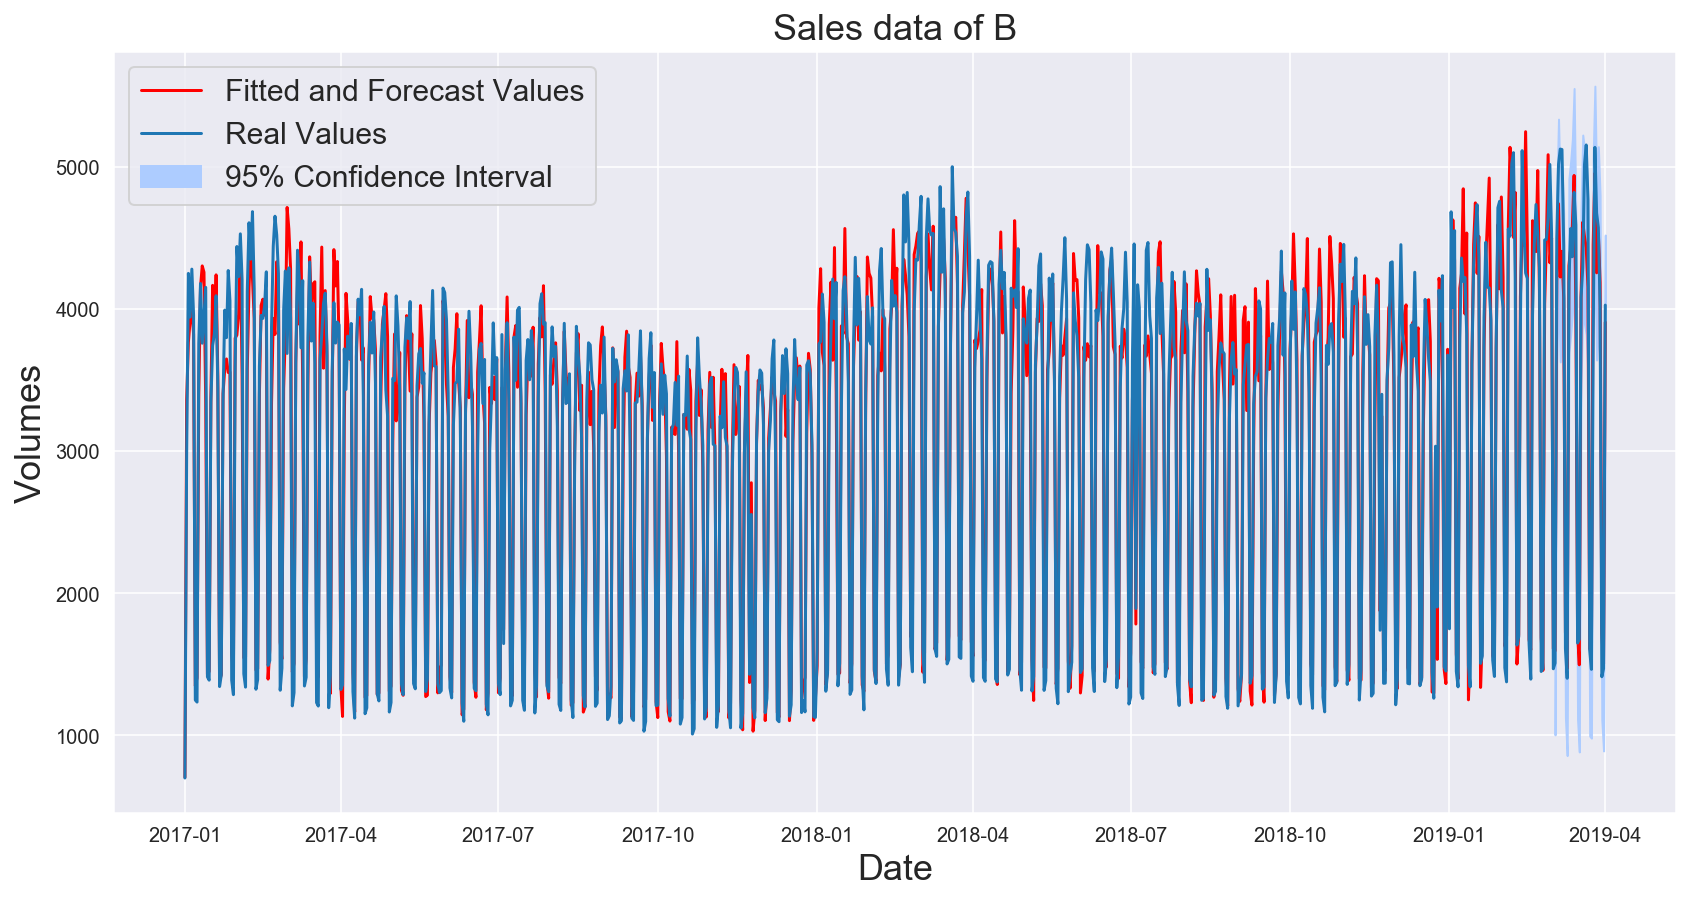

In [384]:
model.plot_data()

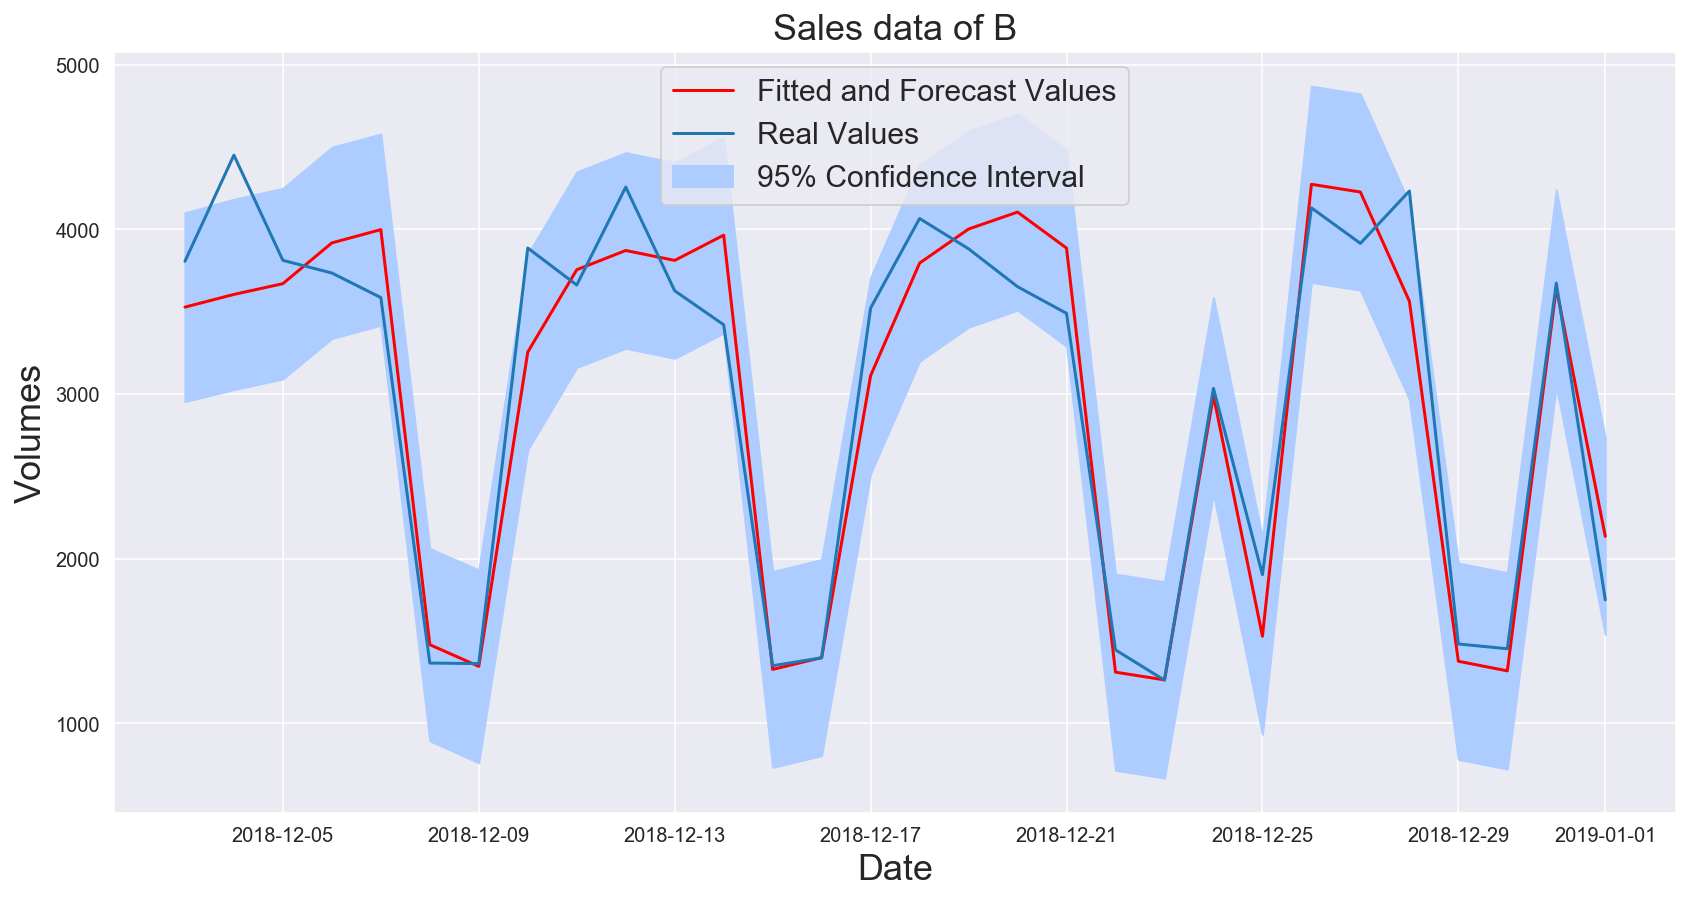

In [370]:
model.plot_data(plot_all = False)

Quick bookkeeping: `external: vol_B/C/A`, `dtype=None`, `q=7`, `p=7 or 0`, `d=0`, `smooth=False` seems work good for the generic model.

There is a strong correlation between B and C sales. When fitting B or C, setting `external = vol_C/B` seems the best.

Here we record the forecasting performance with increasing forecast window

In [305]:
window = [30, 90, 180, 365]
# model (p=7,q=0, d=0) ext = 'vol_B'
forecast_C = {'daily': [6.194513737450497, 7.419691122837761, 8.124896222033, 7.98065692029622], 
              'total':[2.389666020122222, 0.791334118472072, 3.6374651201448462, 3.6905250923937345]}
# model (p=7,q=0, d=0) ext = 'vol_C'
forecast_B = {'daily': [6.706217997540615, 6.793812231914249, 8.825217121948636, 8.890960588602624], 
              'total':[1.893792951438545, 0.7004442541975938, 3.7353568095589833, 3.0229068680130444]}
# model (p=7,q=0, d=0) ext = 'vol_C'
forecast_A_1 = {'daily': [8.925333245884215, 9.484035934449176, 10.304109774700724, 9.909592072685092], 
              'total':[3.9001796395937274, 8.160895044645777, 7.675264942387187, 6.552734498612972]}
# model (p=7,q=0, d=0) ext = 'vol_B'
forecast_A_2 = {'daily': [8.362482453819897,9.614807507142242,11.04180973205832, 10.808548583600667], 
              'total':[1.8754028647732572, 5.638075931159003, 8.579803344310847, 10.234606929096278]}

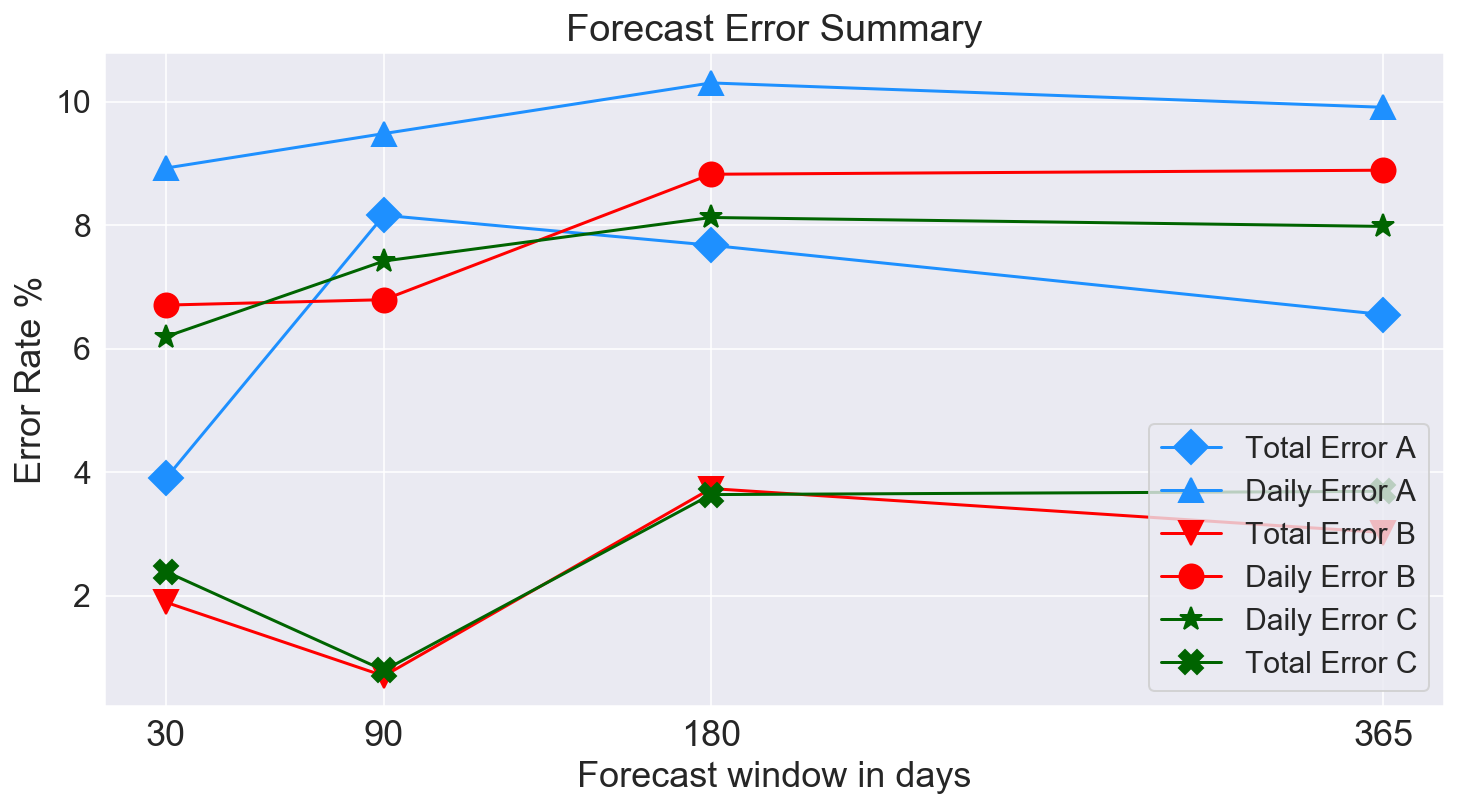

In [350]:
plt.figure(figsize=(12,6))

plt.plot(window, forecast_A_1['total'], marker='D',markersize=12, label='Total Error A', color = 'dodgerblue')
plt.plot(window, forecast_A_1['daily'], marker='^',markersize=12, label='Daily Error A', color = 'dodgerblue')

plt.plot(window, forecast_B['total'], marker='v',markersize=12, label='Total Error B', color = 'red')
plt.plot(window, forecast_B['daily'], marker='o',markersize=12, label='Daily Error B', color = 'red')

plt.plot(window, forecast_C['daily'], marker='*', markersize=12, label='Daily Error C', color = 'darkgreen')
plt.plot(window, forecast_C['total'], marker='X', markersize=12, label='Total Error C', color = 'darkgreen')

plt.xlabel('Forecast window in days', fontsize='18')
plt.ylabel('Error Rate %', fontsize='18')
plt.xticks(window, fontsize=18)
plt.yticks(fontsize=16)
plt.legend(prop={'size': 15})
plt.title('Forecast Error Summary', fontsize = 19)
plt.savefig('figs/error_summary', dpi=400)
plt.show()

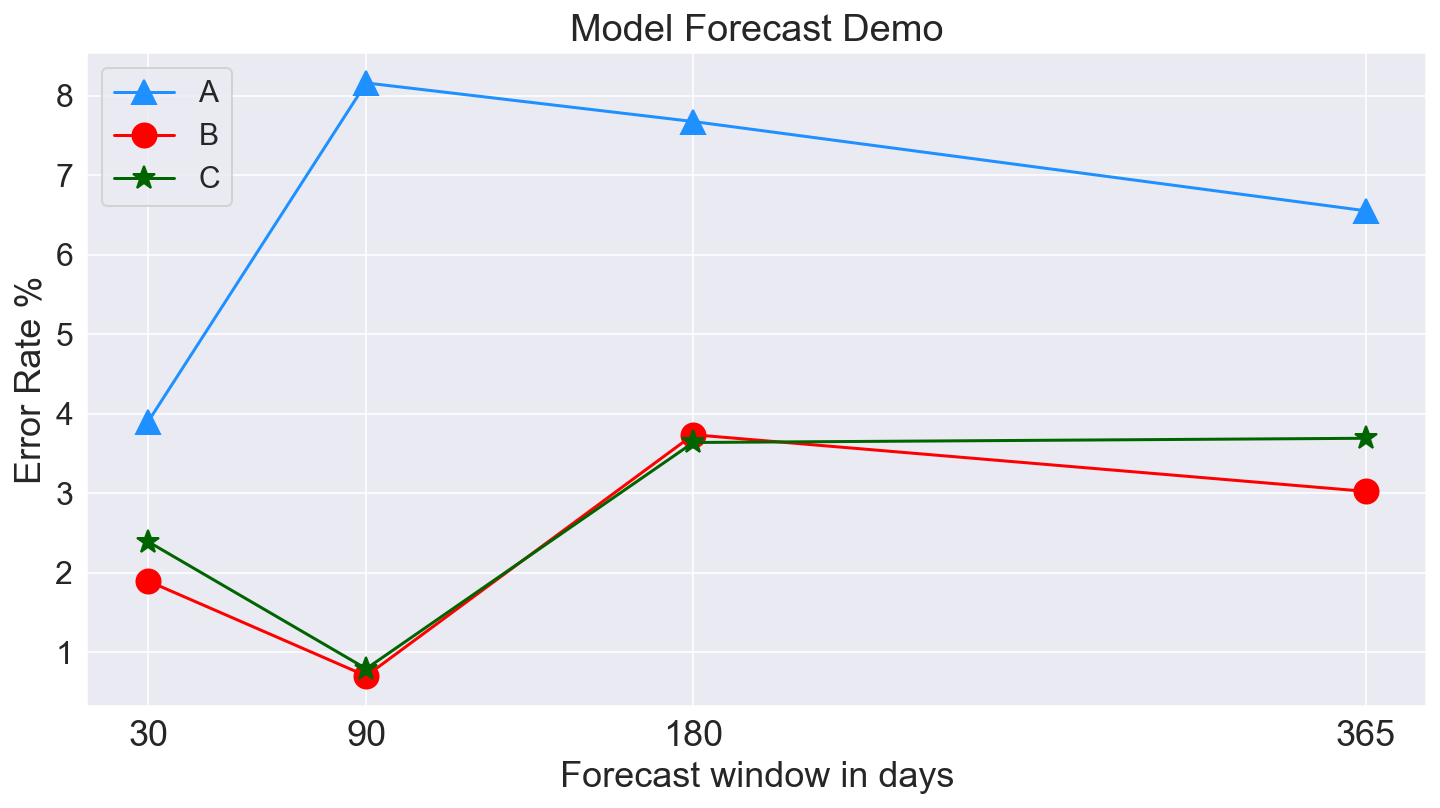

In [455]:
plt.figure(figsize=(12,6))


plt.plot(window, forecast_A_1['total'], marker='^',markersize=12, label='A', color = 'dodgerblue')

plt.plot(window, forecast_B['total'], marker='o',markersize=12, label='B', color = 'red')

plt.plot(window, forecast_C['total'], marker='*', markersize=12, label='C', color = 'darkgreen')


plt.xlabel('Forecast window in days', fontsize='18')
plt.ylabel('Error Rate %', fontsize='18')
plt.xticks(window, fontsize=18)
plt.yticks(fontsize=16)
plt.legend(prop={'size': 15})
plt.title('Model Forecast Demo', fontsize = 19)
plt.savefig('figs/total_error_summary', dpi=400)
plt.show()

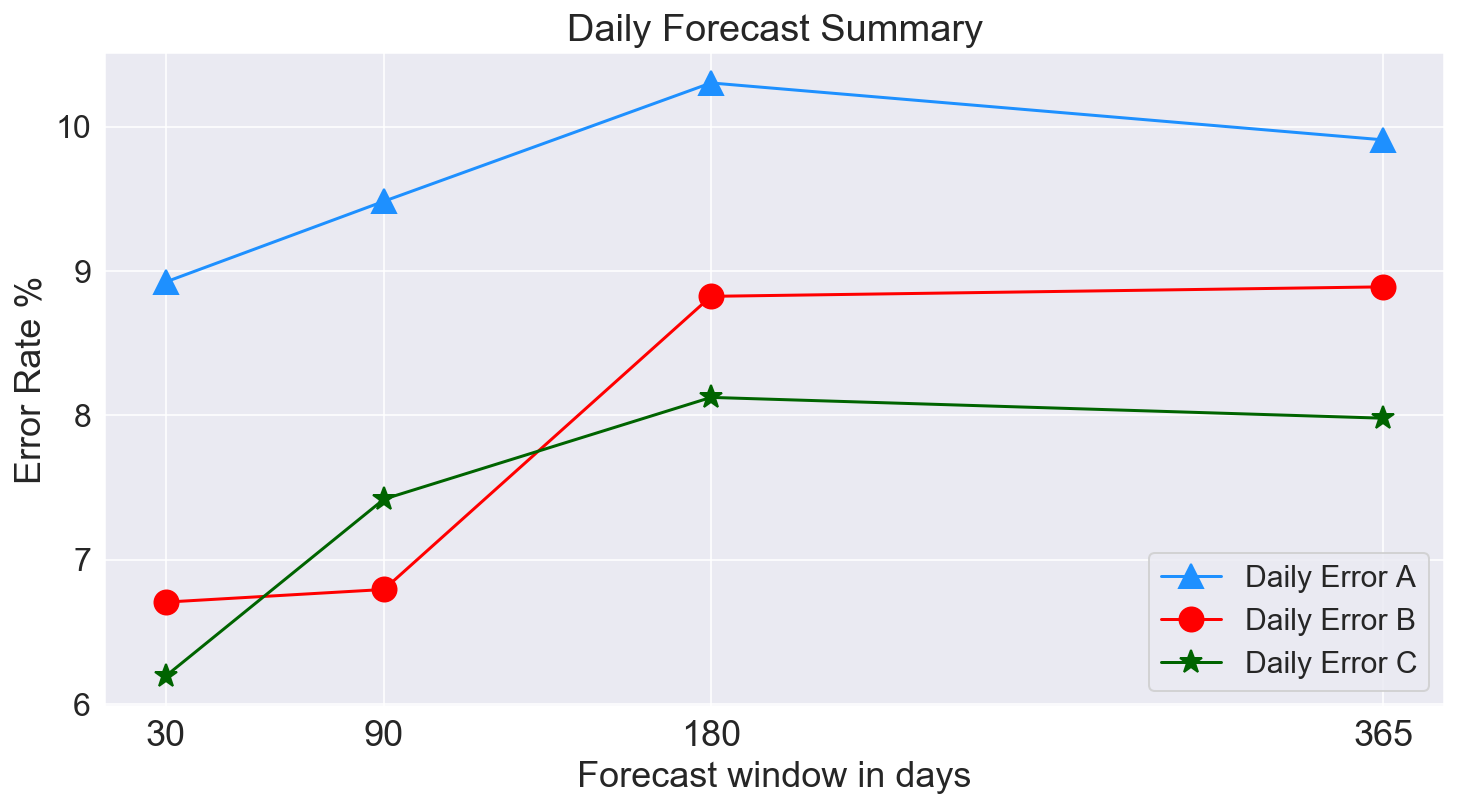

In [346]:
plt.figure(figsize=(12,6))


plt.plot(window, forecast_A_1['daily'], marker='^',markersize=12, label='Daily Error A', color = 'dodgerblue')

plt.plot(window, forecast_B['daily'], marker='o',markersize=12, label='Daily Error B', color = 'red')

plt.plot(window, forecast_C['daily'], marker='*', markersize=12, label='Daily Error C', color = 'darkgreen')


plt.xlabel('Forecast window in days', fontsize='18')
plt.ylabel('Error Rate %', fontsize='18')
plt.xticks(window, fontsize=18)
plt.yticks(fontsize=16)
plt.legend(prop={'size': 15})
plt.title('Daily Forecast Summary', fontsize = 19)
plt.savefig('figs/daily_error_summary', dpi=400)
plt.show()

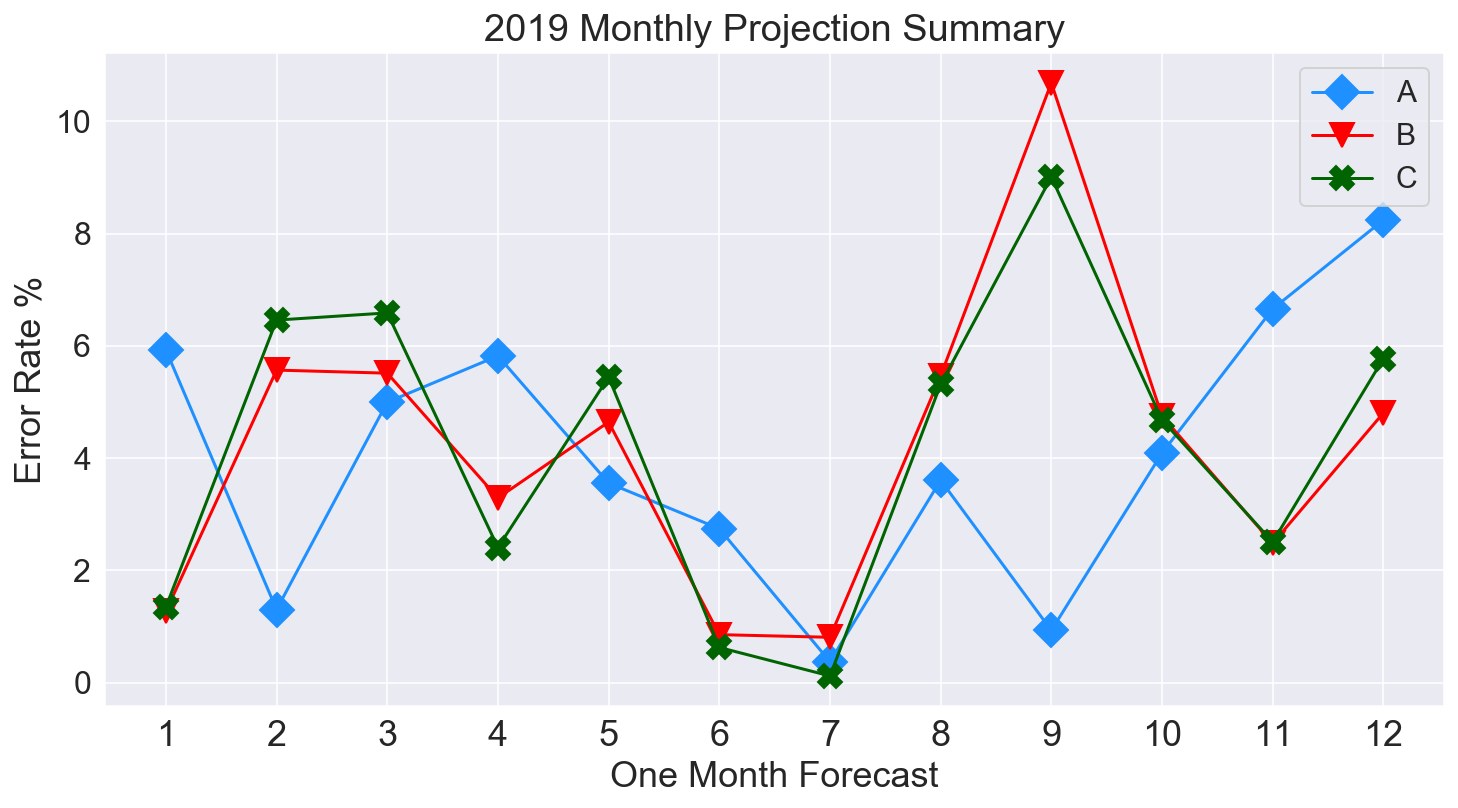

In [453]:
month = list(range(1,13))
plt.figure(figsize=(12,6))

plt.plot(month, montly_forecast_A['total'], marker='D',markersize=12, label='A', color = 'dodgerblue')

plt.plot(month, montly_forecast_B['total'], marker='v',markersize=12, label='B', color = 'red')

plt.plot(month, montly_forecast_C['total'], marker='X', markersize=12, label='C', color = 'darkgreen')

plt.xlabel('One Month Forecast', fontsize='18')
plt.ylabel('Error Rate %', fontsize='18')
plt.xticks(month, fontsize=18)
plt.yticks(fontsize=16)
plt.legend(prop={'size': 15})
plt.title('2019 Monthly Projection Summary', fontsize = 19)
plt.savefig('figs/month_error_summary', dpi=400)
plt.show()

### Detect outliers

In [68]:
def plot_weekday(col = 'vol_A'):
    plt.figure(figsize=(10,7))
    plt.plot(df_new.index, df_new[col], label="A" ,alpha=0.4)
    plt.scatter(df_new.index[(df_new['is_weekday']==True)], df_new[col][(df_new['is_weekday']==True)], label='weekday A', alpha=0.8)
    plt.scatter(df_new.index[(df_new['is_weekday']==False)], df_new[col][(df_new['is_weekday']==False)], label='no weekday A', alpha=0.8)
    plt.scatter(df_new.index[df_new['is_holiday']==True], df_new[col][df_new['is_holiday']==True], label='Holiday', alpha=0.8)

    plt.xlabel("Date", fontsize=18)
    plt.ylabel("Volume", fontsize=18)

    plt.legend()
    plt.show()

In [69]:
def plot_workday(col = 'vol_A'):
    plt.figure(figsize=(10,7))
    plt.plot(df_new.index, df_new[col], label="A" ,alpha=0.4)
    plt.scatter(df_new.index[(df_new['is_workday']==True)], df_new[col][(df_new['is_workday']==True)], label='work day A', alpha=0.8)
    plt.scatter(df_new.index[(df_new['is_workday']==False)], df_new[col][(df_new['is_workday']==False)], label='no workday A', alpha=0.8)
    plt.scatter(df_new.index[df_new['is_holiday']==True], df_new[col][df_new['is_holiday']==True], label='Holiday', alpha=0.8)
    plt.xlabel("Date", fontsize=18)
    plt.ylabel("Volume", fontsize=18)

    plt.legend()
    plt.show()

If we look at the data distinguished by `is_workday`, it looks like there are several outliers in the no workday sales:

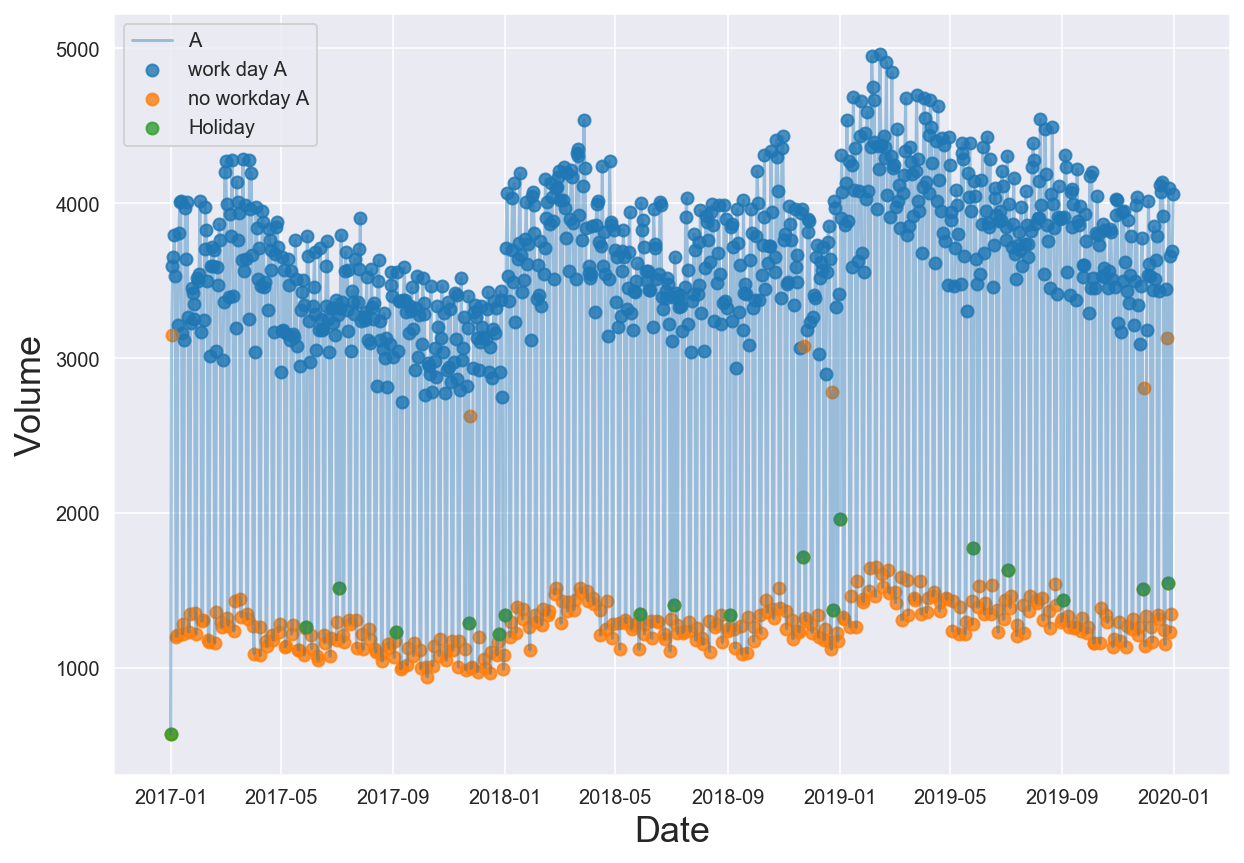

In [70]:
plot_workday(col='vol_C')

But if we look at `is_weekday` instead, those outliers just disappear. So we should not worry about outliers if we only consider `is_weekday` feature. 

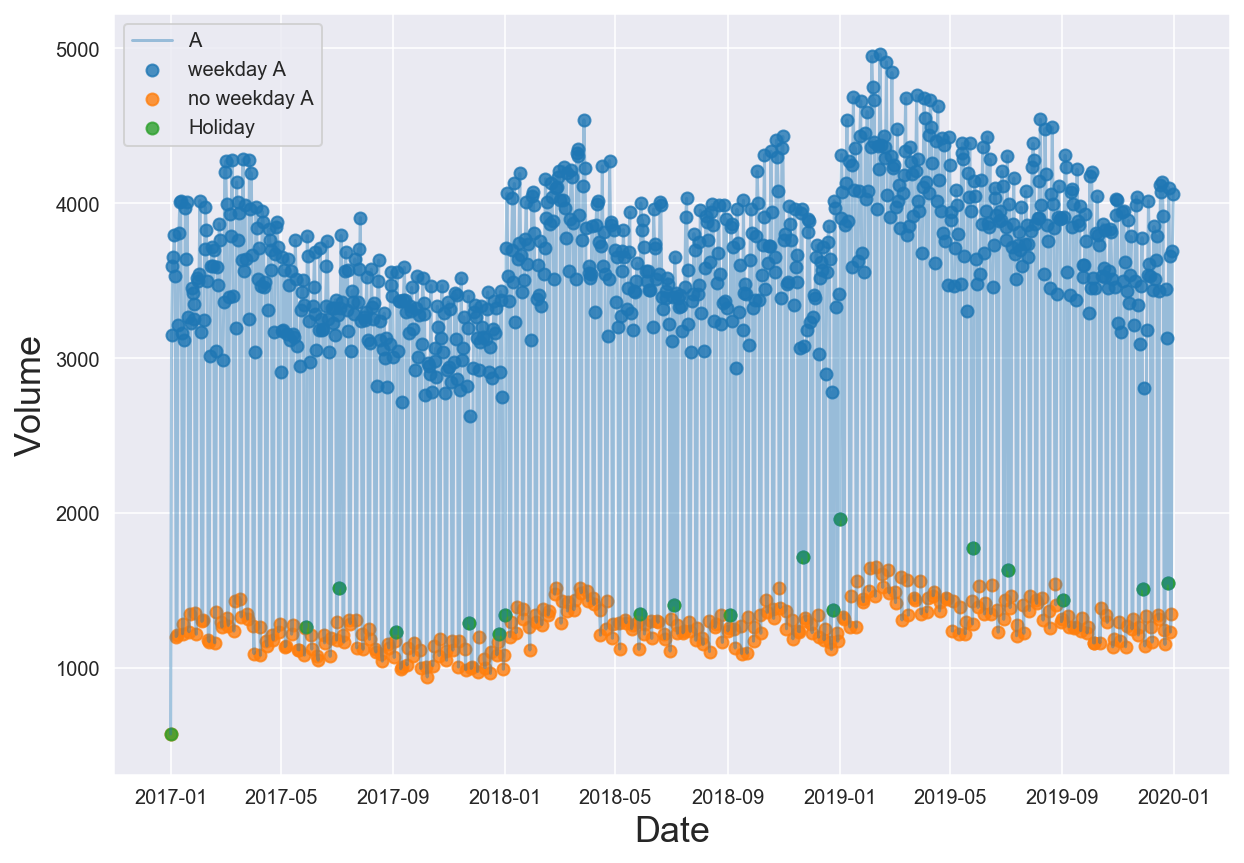

In [71]:
plot_weekday(col='vol_C')

We can use the following code to confirm the observation:

In [72]:
col = 'vol_C'
non_work = df_new[col][(df_new['is_workday']==False)]
too_much = df_new.loc[(df_new[col] > (non_work.mean()+1.96*non_work.std())) & (df_new['is_workday'] == False)]

In [73]:
too_much

,is_weekday,is_workday,is_holiday,vol_A,vol_B,vol_C
date,,,,,,
2017-01-02,1,0,0,5073,2976,3149
2017-11-24,1,0,0,6057,2554,2628
2018-11-23,1,0,0,6890,3399,3076
2018-12-24,1,0,0,6153,3034,2781
2019-01-01,1,0,1,4194,1750,1959
2019-11-29,1,0,0,7183,3238,2809
2019-12-24,1,0,0,7181,3212,3130


On these 'anomalous' huge sale in those not-supposed-to-work days, they are all actually weekdays. The customers just don't take the time off.

Also the `is_holiday` seems don't have too much impact on the overal sale.

In [ ]:
df_new[df_new['is_holiday']==True][['vol_A','vol_B','vol_C']].describe()

Since most holidays are non weekdays, they don't differ much with the ordinary non weekday data.

In [ ]:
df_new[(df_new['is_weekday']==False) & (df_new['is_holiday']==False)][['vol_A','vol_B','vol_C']].describe()

### Exponential Smoothing

In [6]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

window = 180
train = df_new['vol_A'][:-window]
test = df_new['vol_A'][-window:]
mul_mod = ExponentialSmoothing(train, seasonal_periods=365, seasonal='mul')

In [7]:
result = mul_mod.fit()
forecast_values = result.forecast(len(test))

In [8]:
(100*np.abs((test-forecast_values)/test)).mean()

82.20647718004786

### Seasonal-Trend Decomposition

In [9]:
from statsmodels.tsa.seasonal import STL

stl_model = STL(train, trend_deg = 1, seasonal_deg = 1)
stl_fit = stl_model.fit()

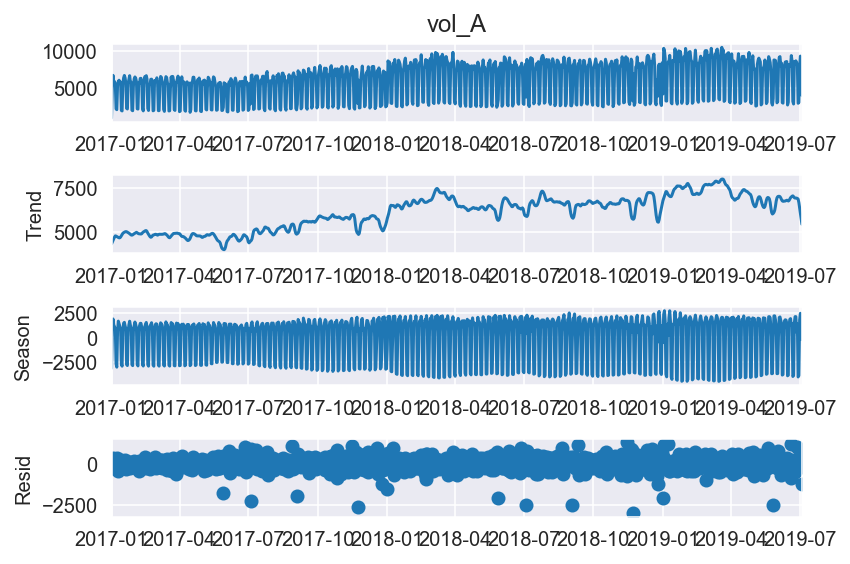

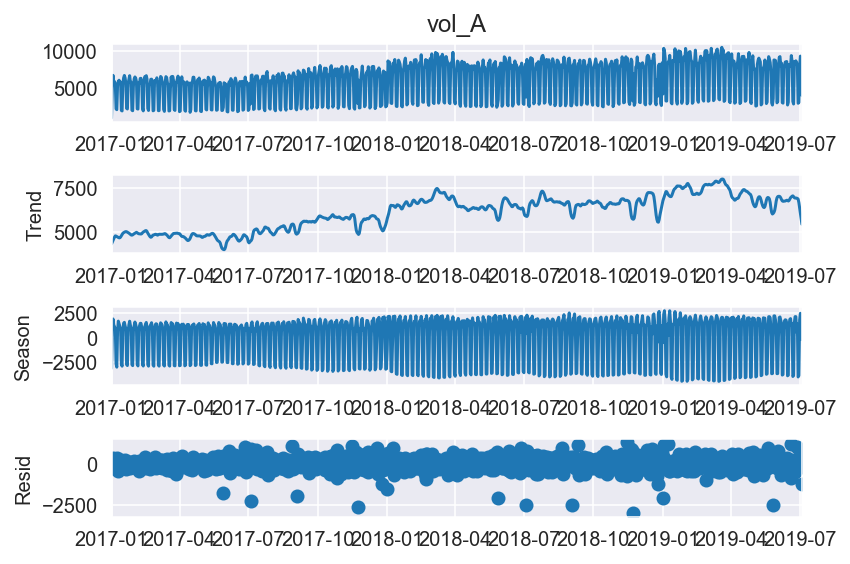

In [10]:
stl_fit.plot()

### VAR

In [139]:
sales_col = ['vol_A', 'vol_B', 'vol_C']
train = df_new[sales_col][:-180]
test = df_new[sales_col][-180:]

In [142]:
from statsmodels.tsa.api import VAR
model = VAR(train)

In [143]:
results = model.fit(7)

In [144]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 29, May, 2020
Time:                     19:41:12
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    36.2121
Nobs:                     908.000    HQIC:                   35.9960
Log likelihood:          -20080.7    FPE:                3.75720e+15
AIC:                      35.8624    Det(Omega_mle):     3.49682e+15
--------------------------------------------------------------------
Results for equation vol_A
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const          628.241655       270.623247            2.321           0.020
L1.vol_A         0.256674         0.046857            5.478           0.000
L1.vol_B        -0.049196         0.098898           -0.497           0.619
L1.v

In [152]:
forecast = results.forecast(train[-7:].values, len(test))

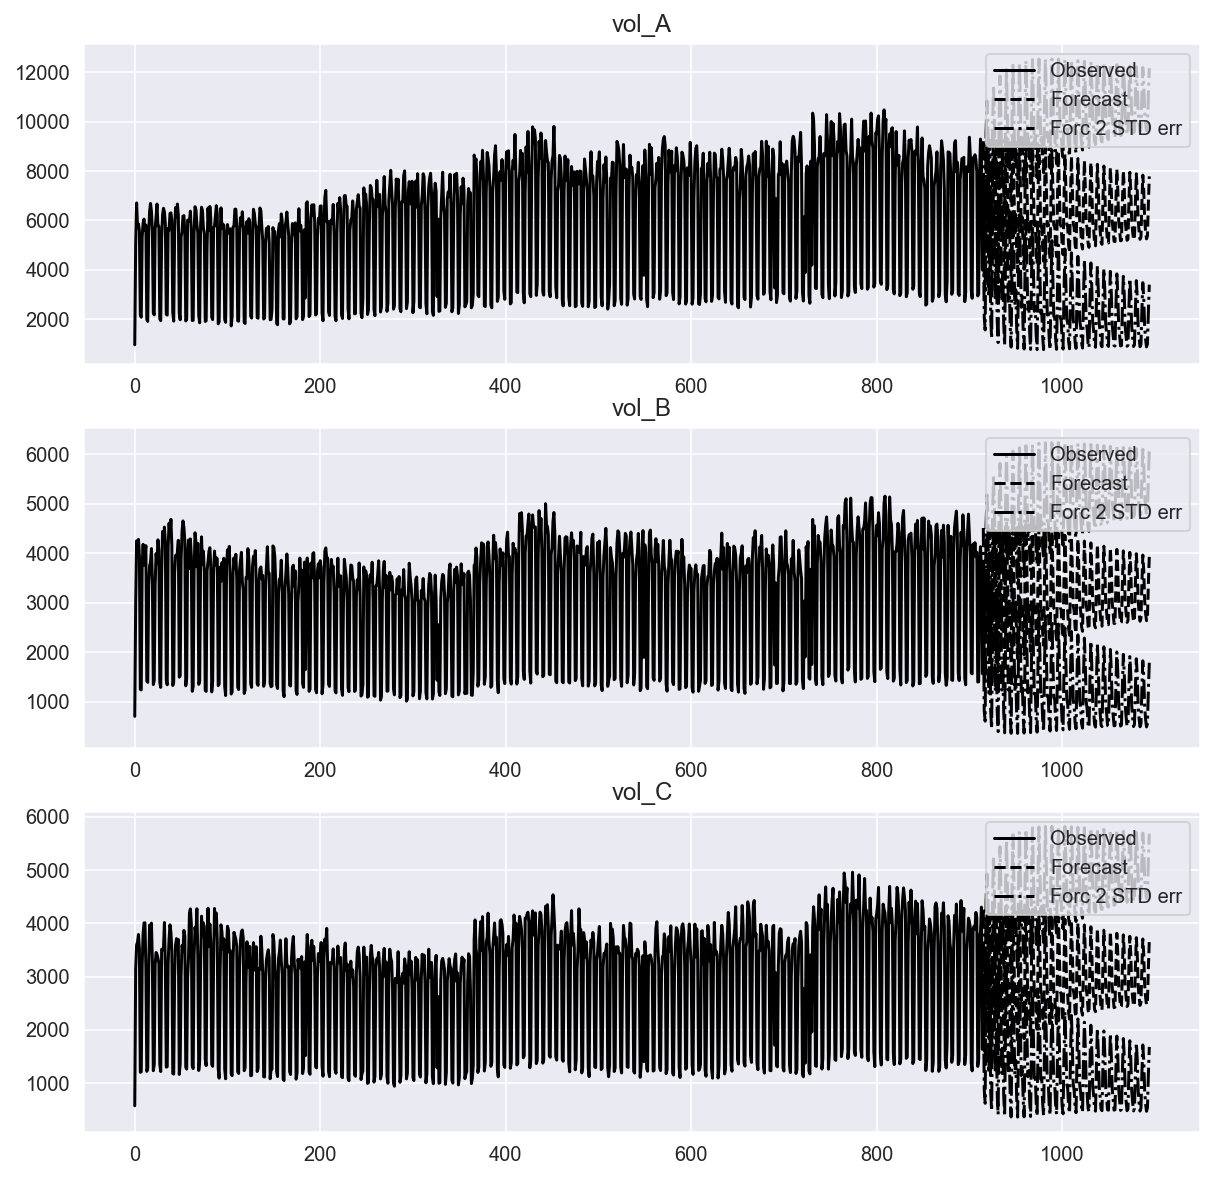

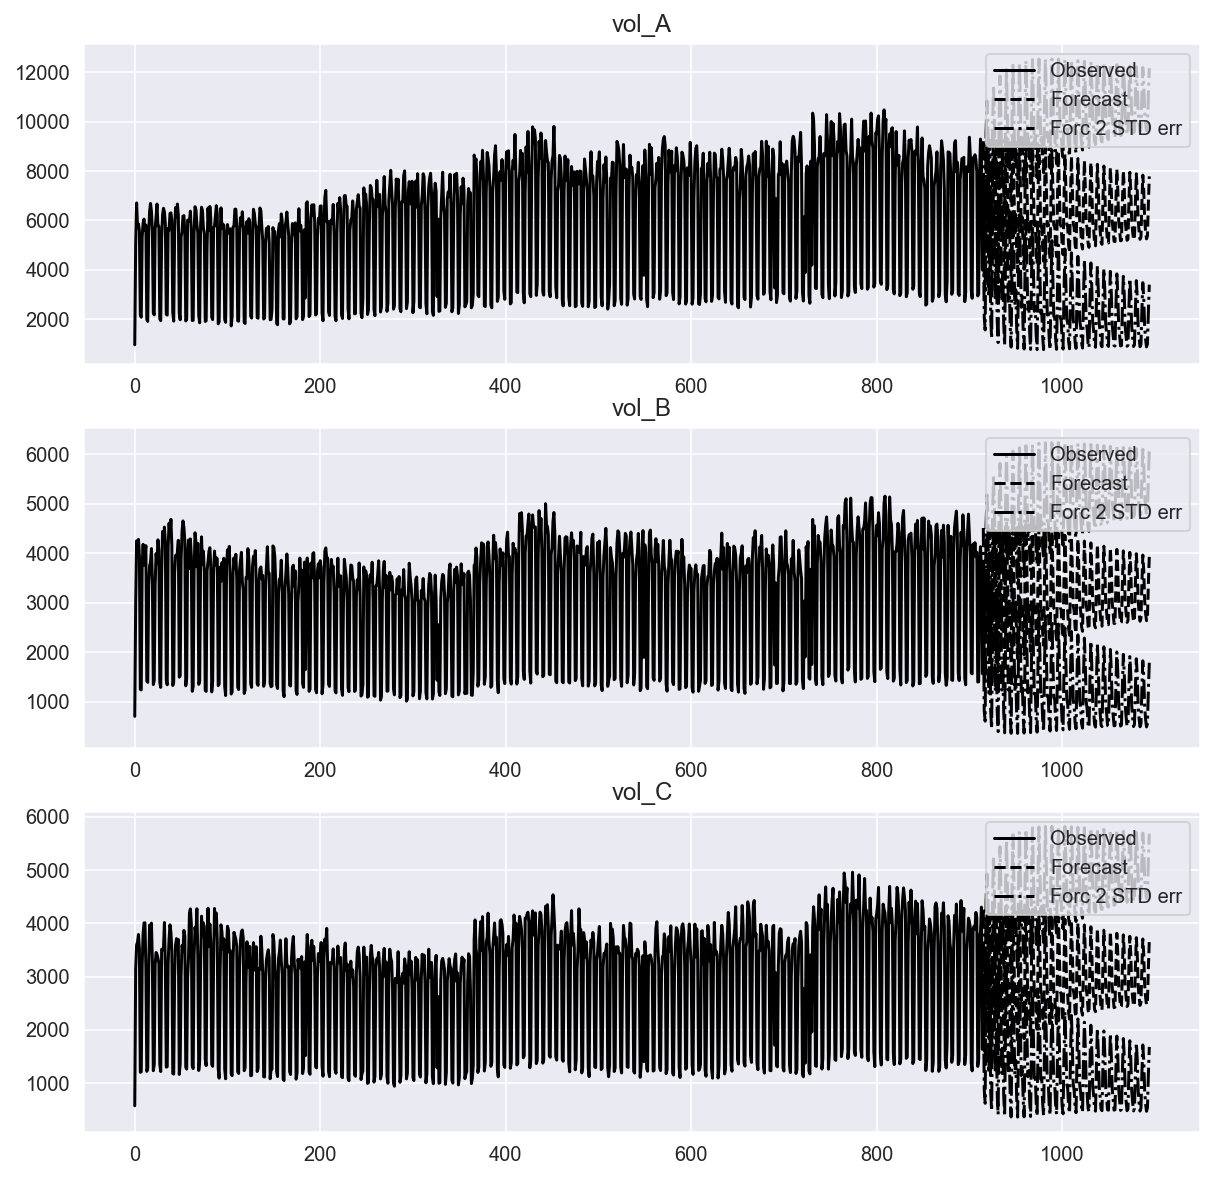

In [155]:
results.plot_forecast(len(test))

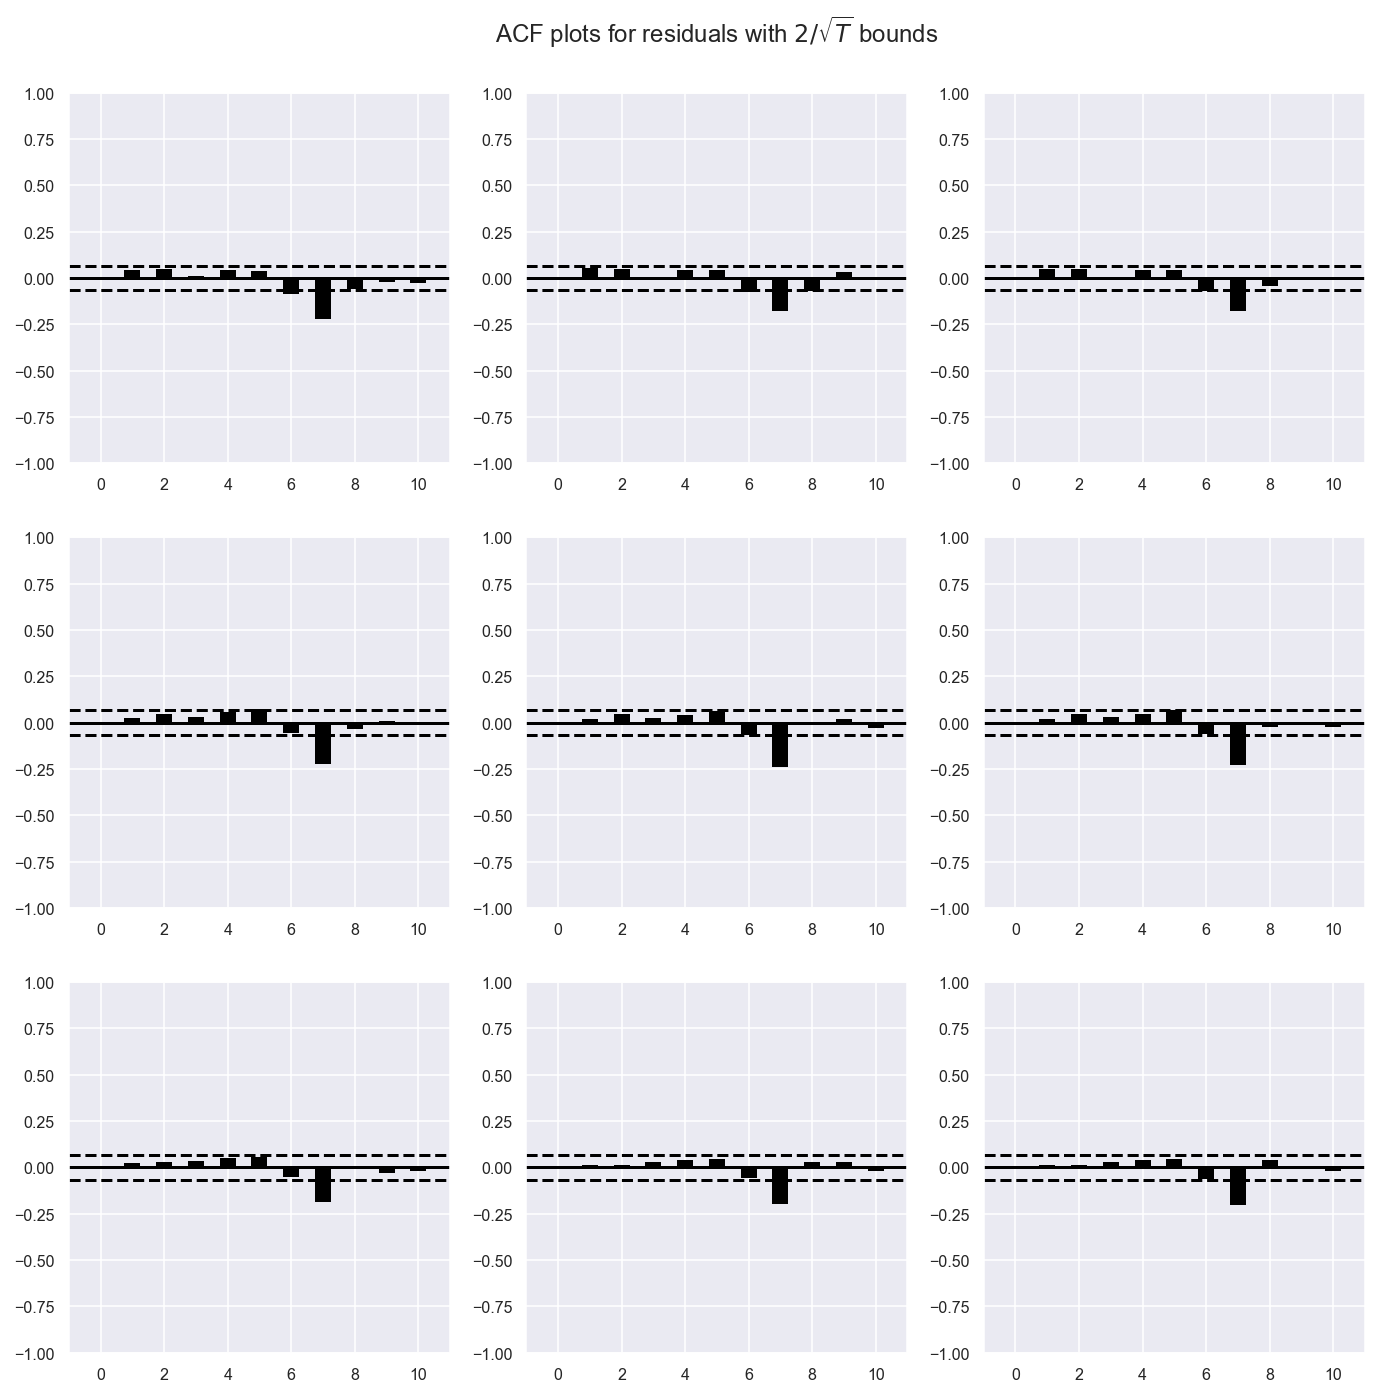

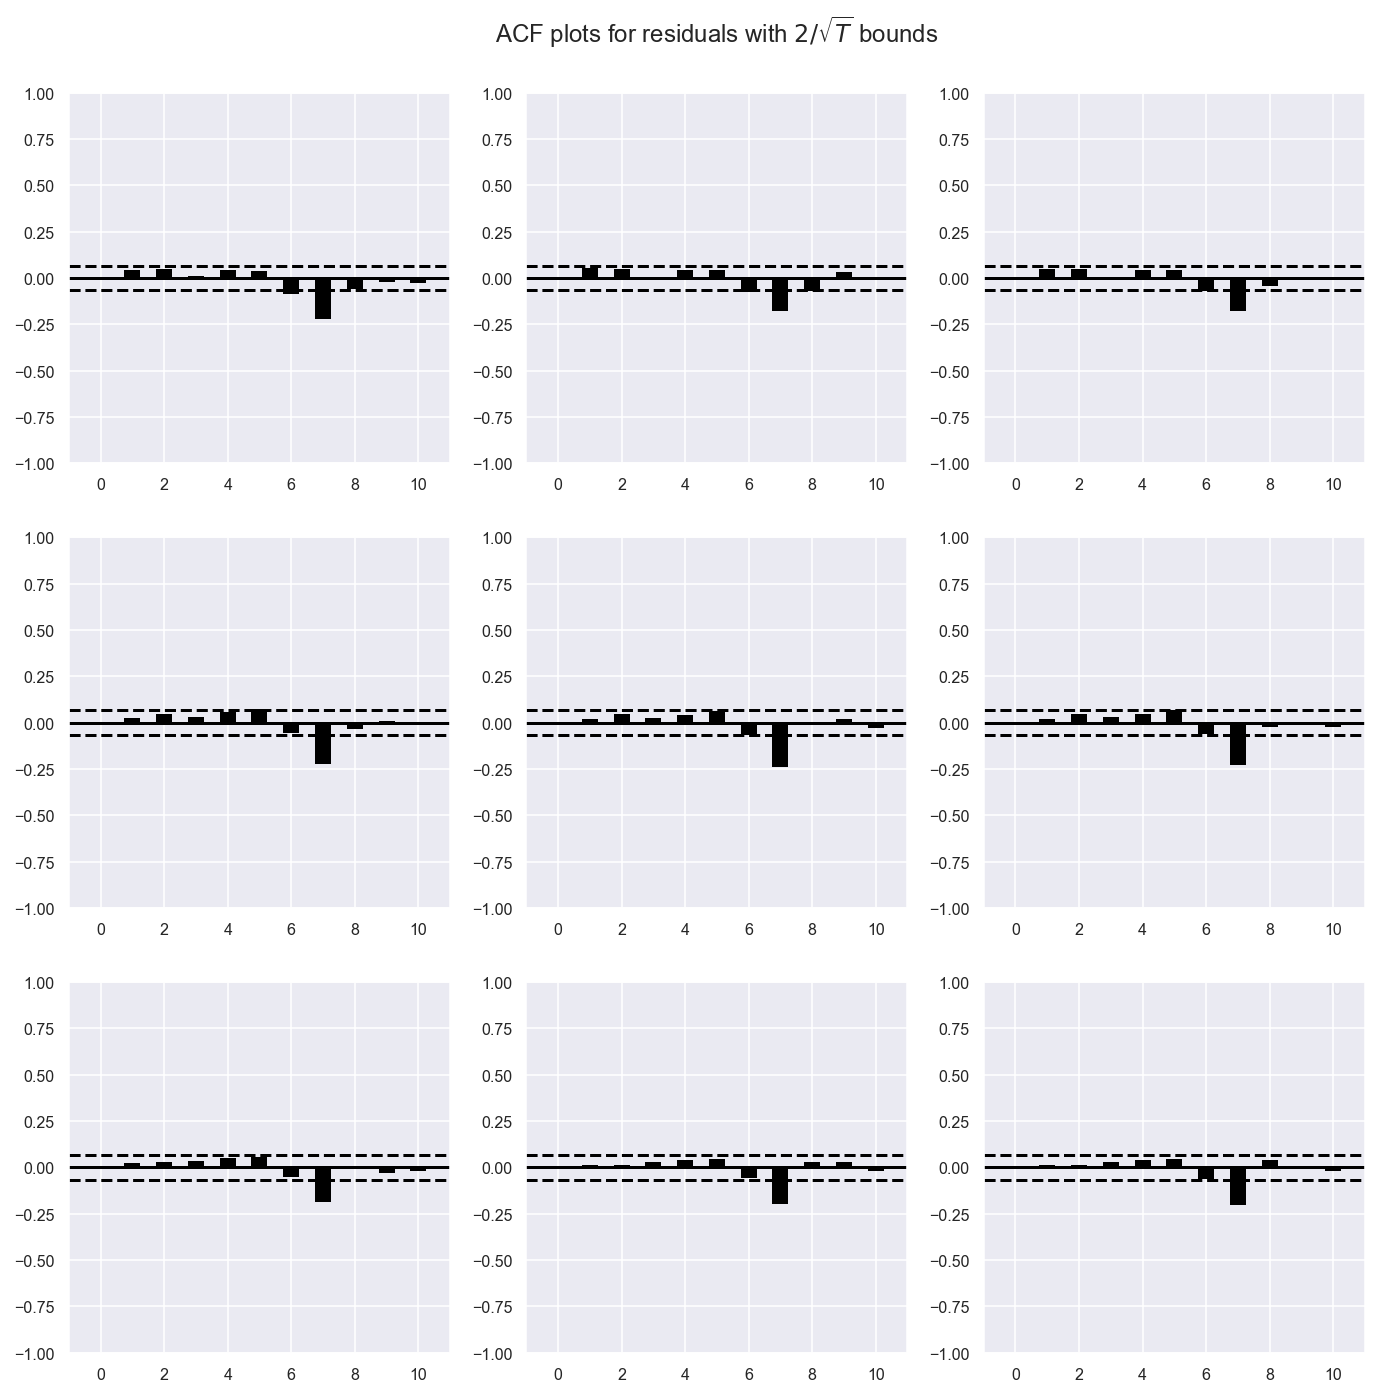

In [146]:
results.plot_acorr()

### Backtest for model selection

In [ ]:
from models.backtest import Backtest_ARIMA

# copy parameters for building the ARIMA model
para_back_test = para_model
month = 30
extra_para = {'p_max': 7, 'q_max': 7, 'd_max': 2, 'method': 'expand', 'span': 12*month, 'slide': 2*month}
# update parameters for backtesting
para_back_test.update(extra_para)

In [ ]:
backtest = Backtest_ARIMA(df_new, **para_back_test)

In [ ]:
backtest.model_selection()

In [ ]:
backtest.mse_scores

In [ ]:
backtest.aic_scores